In [1]:
import os
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### General settings

In [2]:
use_seed = True

if use_seed:
    seed = 42
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
else:
    seed = None

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

Training on cpu


## Import HAR dataset
NOTE: No normalization is done here

In [4]:
### Link to the folder with data
folder_link = "https://drive.google.com/drive/folders/1CeayaGQzOLlWNQoXCATrvNOo93Oe9HYs"

if "Data" not in os.listdir("./"):
  !gdown $folder_link -O ./Data --folder

In [5]:
ds_train = torch.load("./Data/watch_subset2_40_ds_train.pt", map_location=device)
ds_val = torch.load("./Data/watch_subset2_40_ds_val.pt", map_location=device)
ds_test = torch.load("./Data/watch_subset2_40_ds_test.pt", map_location=device)

act_map = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'M': 'kicking',
    'P': 'dribbling',
    'O': 'catch',
    'F': 'typing',
    'Q': 'writing',
    'R': 'clapping',
    'G': 'teeth',
    'S': 'folding',
    'J': 'pasta',
    'H': 'soup',
    'L': 'sandwich',
    'I': 'chips',
    'K': 'drinking',
}

# ATTENZIONE -> qui si seleziona le classi su cui lavorare
labels_mapping = {k:act_map[k] for k in list(act_map.keys())[6:13] if k in act_map}
labels_activity = list(act_map.values())[6:13]

In [6]:
print("Training set \t ---data---\n \tnumber of samples: {}\n \tsample shape: {}".format(
    len(ds_train),next(iter(DataLoader(ds_train, batch_size=1, shuffle=False)))[0].shape))
print("Training set \t ---labels---\n \tnumber of labels: {}\n \tlabel shape: {}".format(
    len(ds_train),next(iter(DataLoader(ds_train, batch_size=1, shuffle=False)))[1].shape))
print("\n")
print("Validation set \t ---data---\n \tnumber of samples: {}\n \tshape: {}".format(
    len(ds_val),next(iter(DataLoader(ds_val, batch_size=1, shuffle=False)))[0].shape))
print("Validation set \t ---labels---\n \tnumber of labels: {}\n \tlabel shape: {}".format(
    len(ds_val),next(iter(DataLoader(ds_val, batch_size=1, shuffle=False)))[1].shape))
print("\n")
print("Test set \t ---data---\n \tnumber of samples: {}\n \tshape: {}".format(
    len(ds_test),next(iter(DataLoader(ds_test, batch_size=1, shuffle=False)))[0].shape))
print("Test set \t ---labels---\n \tnumber of labels: {}\n \tlabel shape: {}".format(
    len(ds_test),next(iter(DataLoader(ds_test, batch_size=1, shuffle=False)))[1].shape))

Training set 	 ---data---
 	number of samples: 25340
 	sample shape: torch.Size([1, 40, 6])
Training set 	 ---labels---
 	number of labels: 25340
 	label shape: torch.Size([1])


Validation set 	 ---data---
 	number of samples: 7240
 	shape: torch.Size([1, 40, 6])
Validation set 	 ---labels---
 	number of labels: 7240
 	label shape: torch.Size([1])


Test set 	 ---data---
 	number of samples: 3621
 	shape: torch.Size([1, 40, 6])
Test set 	 ---labels---
 	number of labels: 3621
 	label shape: torch.Size([1])


In [7]:
# Extract a random sample from the training set
random_sample = next(iter(DataLoader(ds_train, batch_size=1, shuffle=False)))
random_data = random_sample[0]
random_label = random_sample[1]

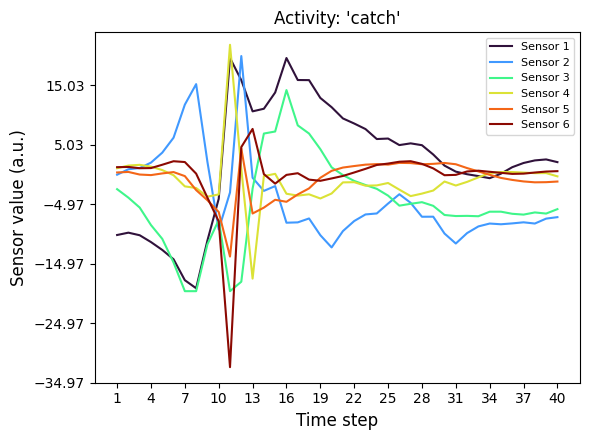

In [8]:
axis_label_size = 12
axis_ticks_size = 10
legend_entry_size = 8

cmap = plt.get_cmap('turbo')

plt.figure(figsize=(6,4.5))
for ch in range(random_data.shape[-1]):
    plt.plot(random_data[0,:,ch].cpu().numpy(), label="Sensor {}".format(ch+1), c=cmap.colors[ch*50])
plt.xlabel("Time step", fontsize=axis_label_size)
plt.ylabel("Sensor value (a.u.)", fontsize=axis_label_size)
plt.xlim((-2,random_data.shape[1]+1))
plt.ylim((torch.min(random_data).item()*1.05-1,torch.max(random_data).item()*1.05+1))
plt.xticks(np.arange(0,random_data.shape[1]+1,3),np.arange(1,random_data.shape[1]+2,3), fontsize=axis_ticks_size)
plt.yticks(np.arange(torch.min(random_data).item()*1.05-1,torch.max(random_data).item()*1.05+1,10), fontsize=axis_ticks_size)
plt.legend(fontsize=legend_entry_size)
plt.title(f"Activity: '{labels_activity[random_label]}'")
plt.tight_layout()
plt.show()

In [9]:
random_data.size()

torch.Size([1, 40, 6])

## SLSTM

In [10]:
import sys
sys.path.append(r'..\src')

In [11]:
from SLSTMNet import SLSTM
from utils import training_loop, val_test_loop
import snntorch.functional as SF

In [12]:
settings = {
    ### Encoding layer ### ->for input x
    "enc_pop": 32,
    "beta_enc": 0.9,   # REMEMBER: the range of values is [0, 1]
    "thr_enc": 1,

    ### slstm cell ###
    # Population encoding size for each gate
    "enc_pop_input": 16,
    "enc_pop_gate": 32,
    "enc_pop_forget": 16,
    "enc_pop_output": 32,

    # beta and threshold for neurons pop
    "beta_forget": 0.9,
    "thr_forget": 1,
    "beta_input": 0.9,
    "thr_input": 1,
    "beta_gate": 0.9,
    "thr_gate": 1,
    "beta_output": 0.9,
    "thr_output": 1,
    "beta_hidden": 0.9,
    "thr_hidden": 1,

    ### Output layer #####
    "beta_out": 0.9 ,   # REMEMBER: the range of values is [0, 1]
    "thr_out": 1,
    ######################
    "nb_epochs": 10,
    "lr": 5e-3,
    "batch_size": 181, ###### DA SISTEMARE PER OGNI BATCH SIZE
}

In [13]:
model = SLSTM(random_data.shape[-1], 4, random_data.shape[1], num_class=7, settings=settings)

In [14]:
loss_fn = SF.ce_count_loss()        
optimizer = torch.optim.Adam(params=model.parameters(), lr=float(settings['lr']))
batch_size = int(settings["batch_size"])

In [15]:
num_epochs = settings["nb_epochs"]

training_results = []
validation_results = []
print(ds_train.__len__())

for epoch in range(num_epochs):

  train_loss, train_acc = training_loop(ds_train, batch_size, model, optimizer, loss_fn, device)
  val_loss, val_acc = val_test_loop(ds_val, batch_size, model, loss_fn, device)

  training_results.append([train_loss, train_acc])
  validation_results.append([val_loss, val_acc])

  print("Epoch {}/{}: \n\ttraining loss: {} \n\tvalidation loss: {} \n\ttraining accuracy: {}% \n\tvalidation accuracy: {}%".format(epoch+1, num_epochs, training_results[-1][0], validation_results[-1][0], np.round(training_results[-1][1]*100,4), np.round(validation_results[-1][1]*100,4)))

25340


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]


Epoch 1/10: 
	training loss: 2.1857190430164337 
	validation loss: 1.9579094439744948 
	training accuracy: 24.2857% 
	validation accuracy: 22.3343%


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Epoch 2/10: 
	training loss: 1.8097770648343223 
	validation loss: 1.7787617027759552 
	training accuracy: 26.0773% 
	validation accuracy: 29.8204%


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


Epoch 3/10: 
	training loss: 1.6888970741203853 
	validation loss: 1.6434999763965608 
	training accuracy: 29.9092% 
	validation accuracy: 31.2983%


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Epoch 4/10: 
	training loss: 1.6327246231692178 
	validation loss: 1.6227335274219512 
	training accuracy: 33.0624% 
	validation accuracy: 28.8674%


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Epoch 5/10: 
	training loss: 1.5987722950322287 
	validation loss: 1.5733528107404708 
	training accuracy: 34.9961% 
	validation accuracy: 32.8729%


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Epoch 6/10: 
	training loss: 1.5811968360628401 
	validation loss: 1.5639019280672073 
	training accuracy: 36.8627% 
	validation accuracy: 34.0884%


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Epoch 7/10: 
	training loss: 1.5516079102243696 
	validation loss: 1.5237016350030899 
	training accuracy: 37.8256% 
	validation accuracy: 39.779%


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Epoch 8/10: 
	training loss: 1.5011218990598405 
	validation loss: 1.5073448956012725 
	training accuracy: 40.0474% 
	validation accuracy: 37.2652%


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Epoch 9/10: 
	training loss: 1.4529746396200998 
	validation loss: 1.44508053958416 
	training accuracy: 41.4601% 
	validation accuracy: 42.9282%


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

Epoch 10/10: 
	training loss: 1.4033665878432138 
	validation loss: 1.4432952940464019 
	training accuracy: 41.8114% 
	validation accuracy: 41.9475%
